In [2]:
import os
import random
import timm
import time
import pickle
from scipy import stats


import albumentations as A
from albumentations.pytorch import ToTensorV2

import torch
import torch.nn as nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

from PIL import Image
from tqdm import tqdm

import cv2
import pandas as pd
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore')

In [3]:
class CONFIG:

    @staticmethod
    def set_seed(SEED):
        os.environ['PYTHONHASHSEED'] = str(SEED)
        random.seed(SEED)
        np.random.seed(SEED)
        torch.manual_seed(SEED)
        torch.cuda.manual_seed(SEED)
        torch.cuda.manual_seed_all(SEED)
        torch.backends.cudnn.benchmark = True
    
    @staticmethod
    def set_path(root_path):
        train_path = f'{root_path}/train/'
        test_path = f'{root_path}/test/'

        return root_path, train_path, test_path

In [4]:
CONFIG.set_seed(0xC0FFE)
root_path, train_path, test_path = CONFIG.set_path('/root/Project/new_data')

In [37]:
train_file = pd.read_csv(f'{root_path}/combined_data.csv')
train_file.head(3)

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10


In [38]:
# 0; 0, 5, 8, 9
# 1; 2, 16
# 2; 1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15

df_class = train_file.copy()
df_class.loc[df_class['target'].isin([0, 5, 8, 9]), 'class'] = 0
df_class.loc[df_class['target'].isin([2, 16]), 'class'] = 1
df_class.loc[df_class['target'].isin([1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15]), 'class'] = 2

In [39]:
df_class.loc[:, ['target', 'class']].value_counts()

target  class
8       0.0      10120
7       2.0       8888
15      2.0       8800
12      2.0       8800
11      2.0       8800
10      2.0       8800
9       0.0       8800
0       0.0       8800
6       2.0       8800
5       0.0       8800
4       2.0       8712
3       2.0       8712
2       1.0       8580
16      1.0       8580
13      2.0       6512
14      2.0       4488
1       2.0       4048
Name: count, dtype: int64

In [40]:
df_class.drop(['target'], axis=1, inplace=True)
df_class

,ID,class
0,002f99746285dfdd.jpg,1.0
1,008ccd231e1fea5d.jpg,2.0
2,008f5911bfda7695.jpg,2.0
3,009235e4c9c07af5.jpg,2.0
4,00b2f44967580c74.jpg,1.0
...,...,...
139035,rotation5_fliped_noised1_mixup_flipud_6dbb0d26...,1.0
139036,rotation6_fliped_noised1_mixup_flipud_6dbb0d26...,1.0
139037,rotation7_fliped_noised1_mixup_flipud_6dbb0d26...,1.0
139038,rotation8_fliped_noised1_mixup_flipud_6dbb0d26...,1.0


In [41]:
sorted_df_class = df_class.sort_values(by='class')
sorted_df_class

,ID,class
69519,rotation9_voronoi0_e6b7972300792a1d.jpg,0.0
29650,rotation0_voronoi1_06c04208033a0ebf.jpg,0.0
29651,rotation1_voronoi1_06c04208033a0ebf.jpg,0.0
29652,rotation2_voronoi1_06c04208033a0ebf.jpg,0.0
29653,rotation3_voronoi1_06c04208033a0ebf.jpg,0.0
...,...,...
79283,rotation3_fliped_3958ff328e348138.jpg,2.0
79282,rotation2_fliped_3958ff328e348138.jpg,2.0
79281,rotation1_fliped_3958ff328e348138.jpg,2.0
79289,rotation9_fliped_3958ff328e348138.jpg,2.0


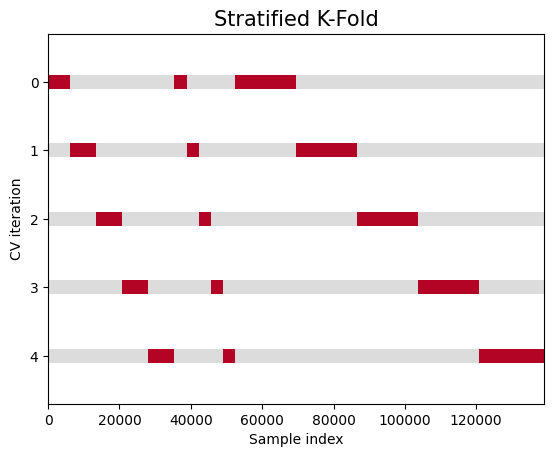

In [42]:
skf = StratifiedKFold(n_splits=5)

# 분할된 데이터를 fold별로 시각화하기 위한 함수를 구성합니다.
# Scikit-learn에서 https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html 사용한 코드를 가져와서 사용하겠습니다.
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(x, y, cv, ax, split_strategy='KFold', group=None, lw=10):
    """Create a sample plot for indices of a cross-validation object."""

    for ii, (tr, tt) in enumerate(cv.split(X=x, y=y, groups=group)):
        # Fill in indices with the training/test groups
        # print(f"Fold {ii} :")
        # print(f"  Train : index={tr[:5]}...")
        # print(f"  Valid : index={tt[:5]}...")
        indices = np.array([np.nan] * len(x))
        indices[tt] = 1
        indices[tr] = 0
        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
            cmap=cmap_cv,
            vmin=-0.2,
            vmax=0.2,
        )

    # Formatting
    yticklabels = list(range(5))

    ax.set(
        yticks=np.arange(len(yticklabels)) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[len(yticklabels) + 0.2, -0.2],
        xlim=[0, len(x)],
    )
    ax.set_title(split_strategy, fontsize=15)
    return ax

fig, ax = plt.subplots()
plot_cv_indices(x=sorted_df_class['ID'],
                y=sorted_df_class['class'],
                cv=skf,
                ax=ax,
                split_strategy='Stratified K-Fold')

train_folds = skf.split(sorted_df_class['ID'], sorted_df_class['class'])

In [43]:
# 데이터셋 클래스를 정의합니다.
class ImageDataset(Dataset):
    def __init__(self, df, path, transform=None):
        self.df = df
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        name, target = self.df.iloc[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        if self.transform:
            img = self.transform(image=img)['image']
        return img, target

In [44]:
# 그라디언트 스케일러 초기화
scaler = GradScaler()

# one epoch 학습을 위한 함수입니다.
def _train_one_epoch(loader, model, optimizer, loss_fn, scheduler, device):
    model.train()
    train_loss = 0
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for images, targets in pbar:
        targets = targets.type(torch.LongTensor)
        
        images = images.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)

        with autocast():
            preds = model(images)
            loss = loss_fn(preds, targets)
            
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss += loss.item()
        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

        pbar.set_description(f"Loss: {loss.item():.4f}")
    
    scheduler.step()

    train_loss /= len(loader)
    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_loss": train_loss,
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret

In [45]:
# one epoch 학습을 위한 함수입니다.
def _val_one_epoch(loader, model, device):
    model.eval()
    
    preds_list = []
    targets_list = []

    pbar = tqdm(loader)
    for images, targets in pbar:
        targets = targets.type(torch.LongTensor)
        images = images.to(device)
        targets = targets.to(device)

        model.zero_grad(set_to_none=True)
        with torch.no_grad():
            preds = model(images)

        preds_list.extend(preds.argmax(dim=1).detach().cpu().numpy())
        targets_list.extend(targets.detach().cpu().numpy())

    train_acc = accuracy_score(targets_list, preds_list)
    train_f1 = f1_score(targets_list, preds_list, average='macro')

    ret = {
        "train_acc": train_acc,
        "train_f1": train_f1,
    }

    return ret, train_f1

In [46]:
# training config
model_name = 'resnet50'

img_size = 224
learning_rate = 1e-4
num_epochs = 10
batch_size = 32
num_workers = 8
patience = 3
T_0 = 5
T_mult = 2
eta_min = 1e-6

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = A.Compose([
    A.Resize(height=img_size, width=img_size),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

test_transform = A.Compose([
    A.LongestMaxSize(max_size=img_size, always_apply=True), 
    A.PadIfNeeded(min_height=img_size, min_width=img_size, border_mode=0, value=(255, 255, 255)), 
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

In [47]:
from sklearn.base import BaseEstimator, ClassifierMixin

class VotingModel(BaseEstimator, ClassifierMixin):
    def __init__(self, estimators):
        super().__init__()
        self.estimators = estimators
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        y_preds = [estimator(X).argmax(dim=1).detach().cpu().tolist() for estimator in self.estimators]
        return stats.mode(y_preds)[0]

In [48]:
def train_model(patience, num_epochs, device):

    # 시작 시간
    since = time.time()

    models = []

    for fold_index, (train_index, validation_index) in enumerate(train_folds):
        
        print()
        print(f'Stratified K-Fold: {fold_index}')
        print('-' * 10)

        model = timm.create_model(
            model_name=model_name,
            pretrained=True,
            num_classes=3
        ).to(device)

        loss_fn = nn.CrossEntropyLoss()
        optimizer = Adam(model.parameters(), lr=learning_rate)
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0, T_mult=T_mult, eta_min=eta_min)
        
        # train
        train_data = sorted_df_class.iloc[train_index, :]
        train_dataset = ImageDataset(
            df=train_data,
            path=train_path,
            transform=train_transform
        )
        train_loader = DataLoader(
            train_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=False
        )

        # validation
        validation_data = sorted_df_class.iloc[validation_index, :]
        validation_dataset = ImageDataset(
            df=validation_data,
            path=train_path,
            transform=train_transform
        )
        validation_loader = DataLoader(
            validation_dataset,
            batch_size=batch_size,
            shuffle=True,
            num_workers=num_workers,
            pin_memory=True,
            drop_last=False
        )

        best_epoch = 0
        best_f1_score = 0
        early_stop_counter = 0
        best_model_weights = None

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            if early_stop_counter >= patience:
                print("Early Stopping....\n")
                break

            # train
            ret = _train_one_epoch(train_loader, model, optimizer, loss_fn, scheduler, device)
            # validation
            ret2, val_f1 = _val_one_epoch(validation_loader, model, device)

            print(f"Loss: {ret['train_loss']:.4f}, train Accuracy: {ret['train_acc']:.4f}, train F1-Score: {ret['train_f1']:.4f}")
            print(f"validation Accuracy: {ret2['train_acc']:.4f}, validation F1-Score: {ret2['train_f1']:.4f}")
            print('-' * 10)
            
            # f1-score을 비교
            if val_f1 > best_f1_score:
                early_stop_counter = 0

                best_epoch = epoch
                best_f1_score = val_f1
                best_model_weights = model.state_dict()
                
            else:
                early_stop_counter += 1

    
        print(f'best epoch: {best_epoch}, best f1 score: {best_f1_score}')

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

        # 가장 좋은 모델의 가중치(w) 가져오기
        model.load_state_dict(best_model_weights)
    
        model_path = f'{root_path}/model/{model_name}'
        if not os.path.exists(model_path):
            os.makedirs(model_path)

        with open(f'{model_path}/fold_{fold_index}' + '.pkl', 'wb') as f:
            pickle.dump(model, f)

        models.append({
            'model': model,
            'weights': best_model_weights,
            'f1_score': best_f1_score,
        })
        
    return models

In [ ]:
# 훈련하기
models = train_model(patience, num_epochs=num_epochs, device=device)

In [ ]:
# 모델 불러오기
models = []

for i in range(5):
    with open(f'{root_path}/model/{model_name}/fold_{i}.pkl', 'rb') as f:
        model = pickle.load(f)
    models.append(model) 

model = VotingModel(models)

In [ ]:
def plot_cm(model:VotingModel, sample_dataloader, device):
    total_labels = []
    total_preds = []

    for images, labels in tqdm(sample_dataloader):
        images = images.to(device)
        labels = labels

        predicts = model.predict(images)

        total_preds.extend(predicts.tolist())
        total_labels.extend(labels.tolist())

    total_preds = np.array(total_preds)
    total_labels = np.array(total_labels)
    _f1_score = f1_score(total_labels, total_preds, average='macro')
    print("Model f1_score : ", _f1_score)

    cm = confusion_matrix(total_labels, total_preds)
    plt.figure(figsize=(20, 20))
    sns.heatmap(cm, annot=True, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

  0%|          | 0/869 [00:00<?, ?it/s]

100%|██████████| 869/869 [01:36<00:00,  8.96it/s]


Model f1_score :  1.0


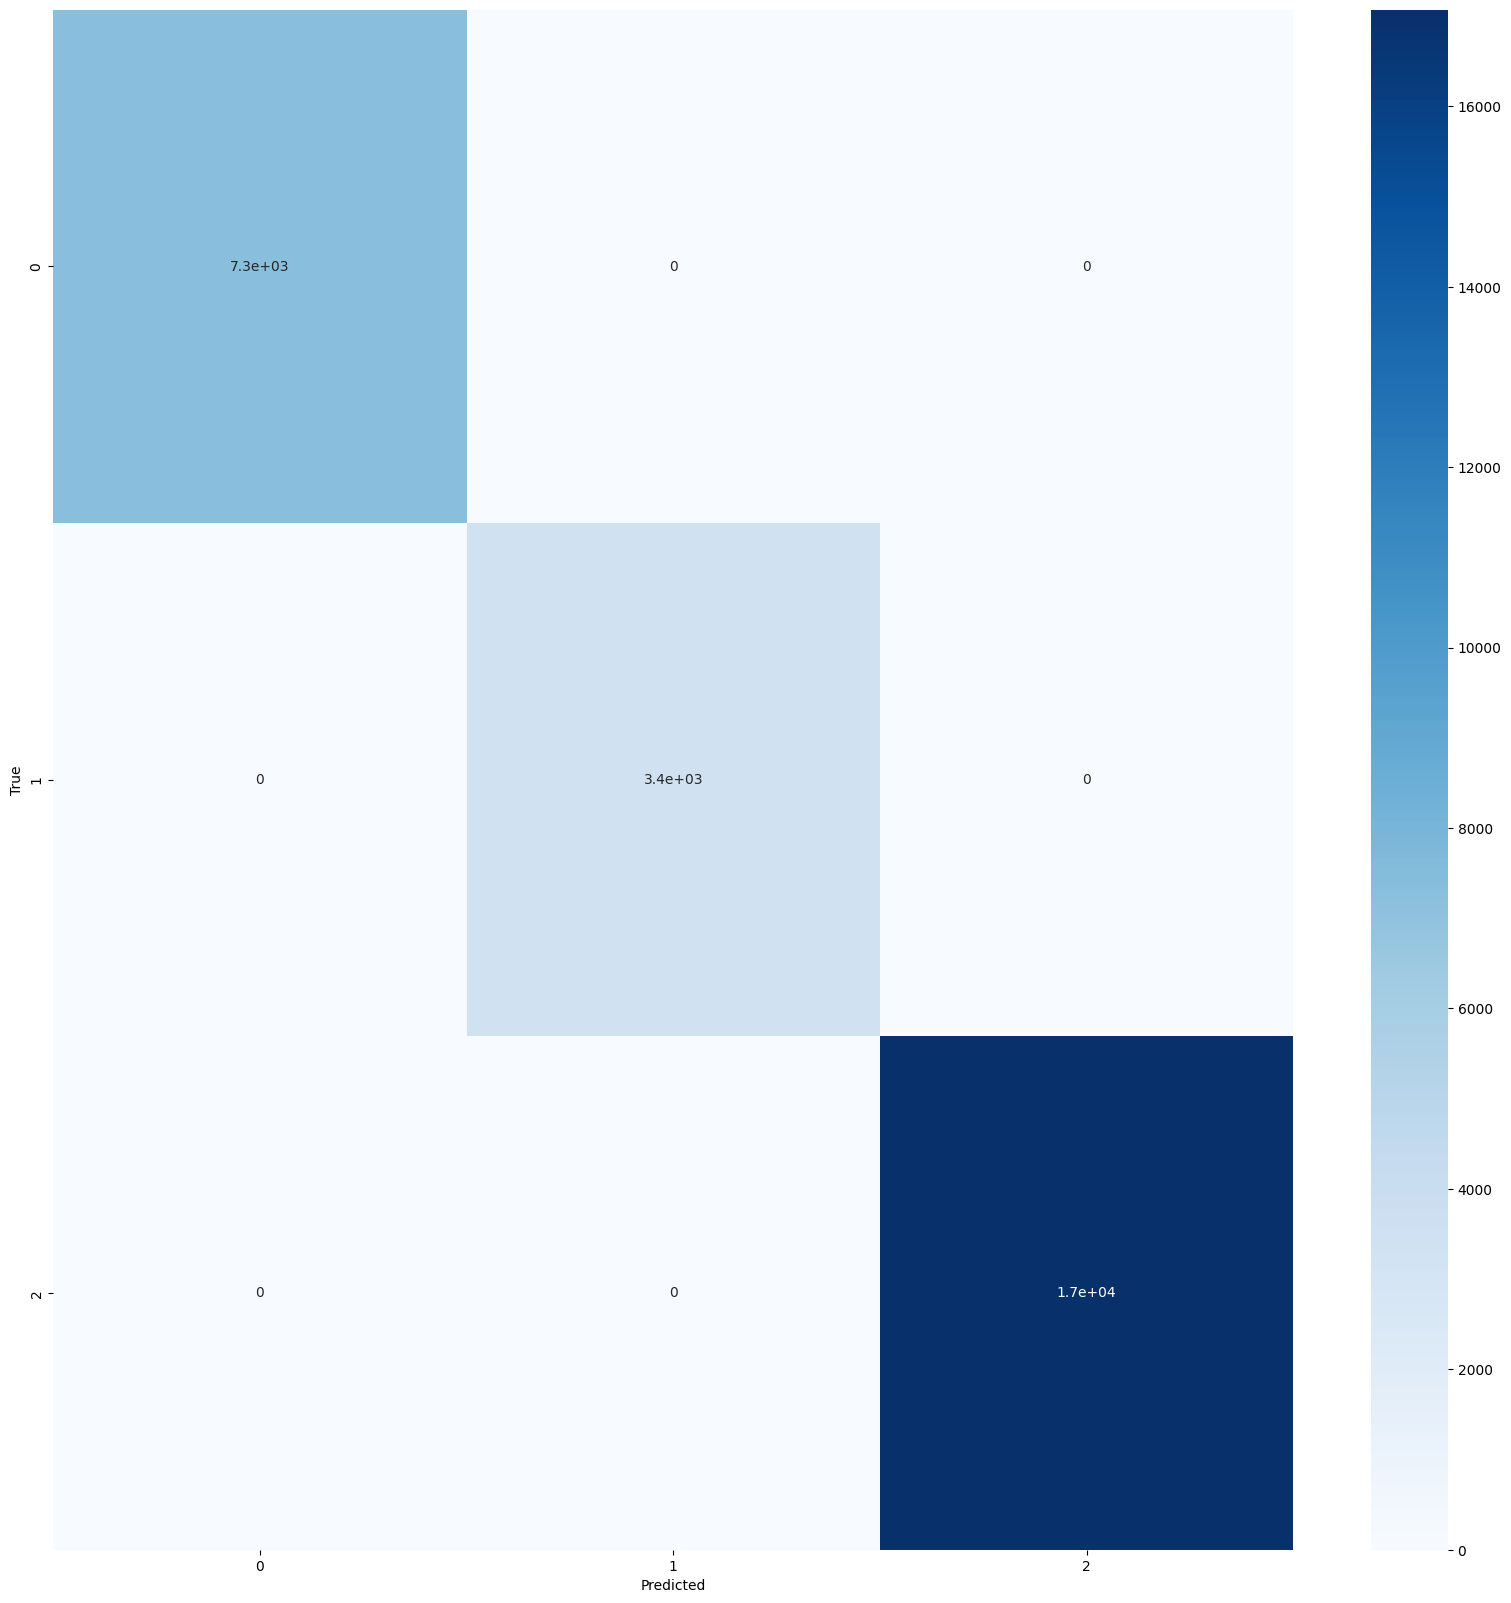

In [ ]:
# 클래스 별 20% 랜덤 추출
sample_file = pd.DataFrame(columns=['ID', 'class'])

for i in range(17):
    temp = sorted_df_class.loc[sorted_df_class['class'] == i].sample(frac=0.2, random_state=0xC0FFE)
    sample_file = pd.concat([sample_file, temp], axis=0)
    

sample_dataset = ImageDataset(
    df=sample_file,
    path=train_path,
    transform=train_transform
)
sample_loader = DataLoader(
    sample_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=False
)
plot_cm(model, sample_loader, device)

In [ ]:
test_file = pd.read_csv(f'{root_path}/sample_submission.csv')
test_file.head(3)

,ID,target
0,0008fdb22ddce0ce.jpg,0
1,00091bffdffd83de.jpg,0
2,00396fbc1f6cc21d.jpg,0


In [ ]:
test_dataset = ImageDataset(
    df=test_file,
    path=test_path,
    transform=test_transform,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=True
)

In [ ]:
preds_list = []

for image, _ in tqdm(test_loader):
    image = image.to(device)

    preds = model.predict(image)
    preds_list.extend(preds.tolist())

pred_df = pd.DataFrame(test_dataset.df, columns=['ID', 'class'])
pred_df['class'] = preds_list

100%|██████████| 99/99 [00:22<00:00,  4.36it/s]


In [ ]:
sample_submission_df = pd.read_csv(f"{root_path}/sample_submission.csv")
assert (sample_submission_df['ID'] == pred_df['ID']).all()

In [ ]:
result_path = f"{root_path}/result"
if not os.path.exists(result_path):
    os.makedirs(result_path)
pred_df.to_csv(f"{result_path}/{model_name}_class.csv", index=False)
pred_df.head()

,ID,class
0,0008fdb22ddce0ce.jpg,1
1,00091bffdffd83de.jpg,2
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,2
4,00901f504008d884.jpg,1


### 소미님 csv

- class 0: card
- class 1: car
- class 2: paper

In [5]:
# 0; 0, 5, 8, 9
# 1; 2, 16
# 2; 1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15

somi_df = pd.read_csv(f'{root_path}/resnet50_class.csv')
somi_df.head()

,ID,class
0,0008fdb22ddce0ce.jpg,1
1,00091bffdffd83de.jpg,2
2,00396fbc1f6cc21d.jpg,0
3,00471f8038d9c4b6.jpg,2
4,00901f504008d884.jpg,1


In [5]:
human_df = pd.read_csv(f'{root_path}/human.csv')
human_df = human_df.loc[:, ['ID', 'Human']]
human_df.head(3)

,ID,Human
0,0008fdb22ddce0ce.jpg,2.0
1,00091bffdffd83de.jpg,12.0
2,00396fbc1f6cc21d.jpg,5.0


In [6]:
human_df.loc[(human_df['Human'].notna()) & (human_df['Human'].isin([0, 5, 8, 9])), 'class'] = 0
human_df.loc[(human_df['Human'].notna()) & (human_df['Human'].isin([2, 16])), 'class'] = 1
human_df.loc[(human_df['Human'].notna()) & (human_df['Human'].isin([1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15])), 'class'] = 2

In [7]:
human_df[['ID', 'class']]

,ID,class
0,0008fdb22ddce0ce.jpg,1.0
1,00091bffdffd83de.jpg,2.0
2,00396fbc1f6cc21d.jpg,0.0
3,00471f8038d9c4b6.jpg,2.0
4,00901f504008d884.jpg,1.0
...,...,...
3135,ffb4b6f619fb60ea.jpg,2.0
3136,ffb54299b1ad4159.jpg,2.0
3137,ffc2c91dff8cf2c0.jpg,0.0
3138,ffc4e330a5353a2a.jpg,0.0


In [9]:
somi_df.loc[(human_df['class'].notna()) & (human_df['class'] != somi_df['class'])]

,ID,class
1880,9c4d18bf8558d643.jpg,1
2670,dbf6dfab9a234e36.jpg,2


In [12]:
def imshow(image_name):

    image_path = f'{test_path}{image_name}'
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    plt.imshow(image)


In [8]:
# 0; 0, 5, 8, 9
# 1; 2, 16
# 2; 1, 3, 4, 6, 7, 10, 11, 12, 13, 14, 15

somi_df2 = pd.read_csv(f'{root_path}/crossvit_18_dagger_240.in1k_class.csv')
somi_df3 = pd.read_csv(f'{root_path}/efficientnet_b5.sw_in12k_ft_in1k class.csv')


In [9]:
somi_df3.loc[somi_df3['class'] != somi_df2['class']]

,ID,class
1748,927f894b0ef786f6.jpg,0


In [10]:
somi_df3.loc[(human_df['class'].notna()) & (human_df['class'] != somi_df3['class'])]

,ID,class
1880,9c4d18bf8558d643.jpg,1


In [21]:
human_df.loc[(human_df['class'].notna()) & (human_df['class'] != somi_df2['class'])]

,ID,Human,class
1748,927f894b0ef786f6.jpg,8.0,0.0
1880,9c4d18bf8558d643.jpg,6.0,2.0


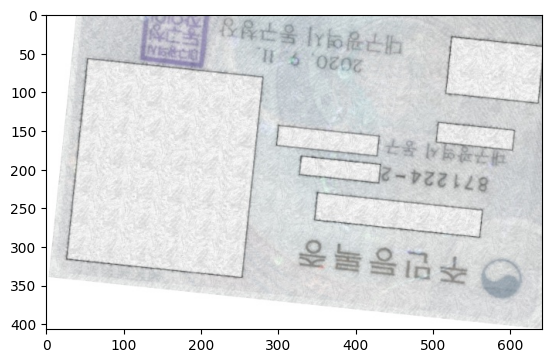

In [22]:
imshow('927f894b0ef786f6.jpg')

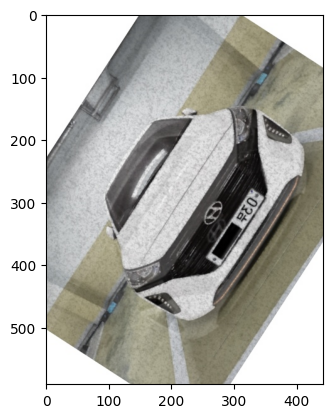

In [13]:
imshow('9c4d18bf8558d643.jpg')

In [6]:
somi_df1 = pd.read_csv(f'{root_path}/resnet50_class.csv')
somi_df2 = pd.read_csv(f'{root_path}/crossvit_18_dagger_240.in1k_class.csv')
somi_df3 = pd.read_csv(f'{root_path}/crossvit_base_240.in1k_class.csv')

In [14]:
somi_df3.loc[somi_df3['class'] != somi_df1['class']]

,ID,class
622,359fab2e1b0ab5e1.jpg,1
1748,927f894b0ef786f6.jpg,2
2549,d32e89d7aef37e4e.jpg,2


In [15]:
somi_df3.loc[somi_df3['class'] != somi_df2['class']]

,ID,class
2549,d32e89d7aef37e4e.jpg,2
2670,dbf6dfab9a234e36.jpg,2


In [11]:
somi_df3.loc[(human_df['class'].notna()) & (human_df['class'] != somi_df3['class'])]

# class 0 : card
# class 1 : car
# class 2 : paper

,ID,class
1748,927f894b0ef786f6.jpg,2
1880,9c4d18bf8558d643.jpg,1
2549,d32e89d7aef37e4e.jpg,2
2670,dbf6dfab9a234e36.jpg,2
